<a href="https://colab.research.google.com/github/francescomontagna/Quantum-Reinforcement-Learning/blob/main/QuantumRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [4]:
import time
import math
import cmath
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from functools import reduce

# Introduction
## Problems
- Since we can access the features, and know the transition probability from a state to another, this RL protocol is model based.
Note that this is in contrast with the uncertainty about a quantum state from the observator point of view: an observator can only access the collapsed state, having no access to the amplitudes. 

In the paper Girolami sent me, they explicitly account for this fact, setting up a model free protocol.  


## Reward
Il principale problema è la formulzione della reward. per ora, l'unica soluzione tale da portare risultati accettabili è stata:
- reward = "grande" per stato terminal
- reward < 0 per stato non terminal  

L'aggiunta di reward negativa a punire ogni step che non portasse a uno stato terminale, è stato cruciale. Infatti, ho usato altri tipi di reward, ma tutte fallimentari  
- fidelity
- fidelity per stato terminale, altrimenti 0
- "grande" per stato terminale, altrimenti 0  

Tutti questi tentativi si sono mostrati fallimentari

## Off Policy
Sono dovuto ricorrere a un'approccio off policy, in quanto un approccio on policy non garantiva esplorazione sufficiente in uno spazio di ricerca così vasto. I risultati erano frtemente limitati, la matrice dei weight non vedeva mai alcune azioni, il cui valore rimaneva 0 per ogni features. I risultati erano in media peggiori di un' approccio Random.  
Andando a usare una bahaviour policy completamente randomica, e una target policy completamente greedy, i risultati sono notavolmente migliorati. 

# Quantum Setup

### Qubit

In [5]:
class Qubit:
  def __init__(self, amplitudes):
    """
    Args:
      amplitudes (np.array): amplitudes of the |0>, |1> vectors
    """
    error = "Error: sum of squared amplitudes must be = 1"
    assert math.isclose(reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, amplitudes)), 1, rel_tol = 1e-2), error
    self._amplitudes = amplitudes

  def qubit(self):
    return self._amplitudes
    

class Basis(Qubit):
  def __init__(self, index):
    """
    Args:
      index: index of the position = 1
    """
    amplitudes = np.zeros((2, ))
    amplitudes[index] += 1
    super().__init__(amplitudes)

### Quantum State

In [6]:
class QuantumState:
  def __init__(self, amplitudes): 

    # We assume computational basis
    self._basis = {
        '00': [Basis(0), Basis(0)],
        '01': [Basis(0), Basis(1)],
        '10': [Basis(1), Basis(0)],
        '11': [Basis(1), Basis(1)],
    }

    a1, a2, a3, a4 = amplitudes
    self._amplitudes = {
        '00': a1,
        '01': a2,
        '10': a3,
        '11': a4
    }
    
    self._keys = list(self._basis.keys())

    error = "Error: sum of squared amplitudes must be = 1"
    val = reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, amplitudes))
    assert math.isclose(val, 1, rel_tol = 1e-2), error + f" instead is {val}"

  def get_amplitudes(self):
    return np.array(list(self._amplitudes.values()))

  def get_features(self):
    real = np.real(list(self._amplitudes.values()))
    imag = np.imag(list(self._amplitudes.values()))
    return np.concatenate((real, imag))

  def apply_gate(self, gate, inplace = False):
    updated_amplitudes = gate.apply(self)
    if inplace:
      self._amplitudes = updated_amplitudes
      return None

    return QuantumState(list(updated_amplitudes.values()))

  def fidelity_score(self, other):
    # TODO: check on nielsen, implement well.
    # This implementation is from paper
    """
    Args:
      other (QuantumState): measure the fidelity between self and another quantum state
    Return:
      fidelity (float): fidelity score between [0, 1]
    """
    # Inner product can be computed in terms of matrix representation. Page 67 Nielsen-Chuang
    return np.square(abs(np.matmul(np.conj(self.get_amplitudes()), other.get_amplitudes())))

### Quantum Gates

In [7]:
class QuantumGate:
  def __init__(self, name, unitary, target):
    """
    Args: 
      unitary: 2x2 unitary operator
      target: 0 or 1 to denote the qubit the matrix is acting on
    """
    self._name = name
    self._U = unitary.flatten()
    self._target = target


  def apply(self, quantum_state):
    """
    Args:
      quantum_state (QuantumState): quantum state to which apply the quantum operator
    Return:
      updated (dict): didctionary with updated amplitudes
    """
    # Directly implement update rule on the amplitudes for a 2 qubits case. 
    # NOTE: This approach is not scalable! Refine or use qiskit for more than 2 qubits
    a_00, a_01, a_10, a_11 = quantum_state.get_amplitudes()
    updated = dict()

    if self._target == 0:
      updated['00'] = self._U[0]*a_00 + self._U[1]*a_10
      updated['01'] = self._U[0]*a_01 + self._U[1]*a_11
      updated['10'] = self._U[2]*a_00 + self._U[3]*a_10
      updated['11'] = self._U[2]*a_01 + self._U[3]*a_11

    else:
      updated['00'] = self._U[0]*a_00 + self._U[1]*a_01
      updated['01'] = self._U[2]*a_00 + self._U[3]*a_01
      updated['10'] = self._U[0]*a_10 + self._U[1]*a_11
      updated['11'] = self._U[2]*a_10 + self._U[3]*a_11

    # Check if amplitudes still satisfy condition
    normalization = reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, updated.values()))
    error = f"Error: sum of squared amplitudes must be = 1.\n Amplitudes: {list(updated.values())}, summing up to {normalization}"
    assert math.isclose(normalization, 1, rel_tol = 1e-2), error
    
    return updated


class CNOT(QuantumGate):
  def __init__(self, control):
    """
    Args:
      control (int): if 0, first qubit is the control, else second
    Return:
      result (QuantumState): quantum state with amplitudes modified
    """
    self._control = control
    super().__init__('cnot', np.array([[0, 1], [1, 0]]), 1-control)


  def apply(self, quantum_state):
    """
    Args:
      state (QuantumState): quantum state to which apply the quantum operator
    Return:
      result (QuantumState): quantum state with amplitudes modified
    """
    # Directly implement update rule on the amplitudes for a 2 qubits case. 
    # NOTE: This approach is not scalable! Refine or use qiskit for more than 2 qubits
    a_00, a_01, a_10, a_11 = quantum_state.get_amplitudes()
    updated = dict()

    if self._control == 0: # Then target = 2nd: if 1st qubit == 1, flip 2nd qubit.
      updated['00'] = a_00
      updated['01'] = a_01
      updated['10'] = self._U[0]*a_10 + self._U[1]*a_11
      updated['11'] = self._U[2]*a_10 + self._U[3]*a_11

    if self._control == 1: # Then control = 1st: if 2nd qubit == 1, flip 1st qubit.
      updated['00'] = self._U[0]*a_00 + self._U[1]*a_10
      updated['01'] = self._U[0]*a_01 + self._U[1]*a_11
      updated['10'] = a_10
      updated['11'] = a_11

    # Check if amplitudes still satisfy condition
    normalization = reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, updated.values()))
    error = f"Error: sum of squared amplitudes must be = 1.\n Amplitudes: {list(updated.values())}, summing up to {normalization}"
    assert math.isclose(normalization, 1, rel_tol = 1e-2), error
    
    return updated

### Gates List

In [8]:
# TODO: compare results with qiskit
class Gates:
  def __init__(self):
    gates = dict()
    self._num_gates = 0

    # Useful
    targets = [0, 1]
    j = 1j # complex unit

    ########### CNOT ###########
    gates['CNOT'] = CNOT(control = 0)
    self._num_gates += 1

    ########### Rotations ###########
    angles_names = ['pi', '2pi/3', 'pi/2', 'pi/3', 'pi/4']
    angles_values = (math.pi / 2) * np.array([1, 2/3, 1/2, 1/3, 1/4])
    angles = {k:v for k,v in zip(angles_names, angles_values)}

    # Rx
    for name, theta in angles.items():
      for t in targets:
        key = 'Rx' + str(t) + '(' + name + ')'
        gates[key] = QuantumGate(key, np.array([[math.cos(theta), -j*math.sin(theta)],
                                                      [-j*math.sin(theta), math.cos(theta)]]), t)
        self._num_gates += 1
        
    # Ry
    for name, theta in angles.items():
      for t in targets:
        key = 'Ry' + str(t) + '(' + name + ')'
        gates[key] = QuantumGate(key, np.array([[math.cos(theta), -math.sin(theta)],
                                                      [math.sin(theta), math.cos(theta)]]), t)
        self._num_gates += 1

    # Rz
    for name, theta in angles.items():
      for t in targets:
        key = 'Rz' + str(t) + '(' + name + ')'
        gates[key] = QuantumGate(key, np.array([[cmath.exp(-j*theta), 0],
                                                      [0, cmath.exp(j*theta)]]), t)
        self._num_gates += 1

    self._mapping = list(gates.keys())
    self._gates = list(gates.values())

  def num_gates(self):
    return self._num_gates

In [ ]:
# TODO: Compare simulation with qiskit results
gates = Gates()
q = QuantumState(np.array([0.4j, 0.3, 0.6, 0.624]))
old_amplitudes = q.get_amplitudes()
for g, name in zip(gates._gates, gates._mapping):
  print("Gate " + name)
  q.apply_gate(g, inplace = True)
  new_amplitudes = []
  for val in q.get_amplitudes():
    new_amplitudes.append("{:.3}".format(val))

  print("Applied gate " + name + f" to qubit with amplitudes {old_amplitudes}.\n" +
        f"Updated amplitudes: {new_amplitudes}")
  
  print("\n\n")

# RL Setup

## Environment

In [35]:
# LinearModel of the environment
class LinearModel:
  def __init__(self, initial_state, target_state, tolerance):
    """
    Args:
      initial_state (QuantumState): initial state of the system
      target_state (QuantumState): target state of the system
      tolerance (float): tolerance in terms of fidelity score
    """
    self._initial_state = initial_state
    self._target_state = target_state
    self._tolerance = tolerance # tolerance in terms of fidelity between
    self._quantum_gates, self._mapping, self._num_gates = self.gates_set()
    self._terminal_fidelity = 0 # used to retrieve the info at the end of an episode
    self._terminal_state = None # used to retrieve the info at the end of an episode
    
    # Used to initialize env from scratch.
    self.reset() 

    assert initial_state.fidelity_score(target_state) < (1-tolerance), f"The two state are the same up to {tolerance} tolerance"

    
  def gates_set(self):
    """
    Returns:
      gates._gates (List[QuantumGate]): return the list with available QuantumGate objects
      gates._mapping (Dict[String: Int]): dicitonary mapping a gate to its action index
      gates.num_gates() (int): number of available gates (actions)
    """
    gates = Gates()
    return gates._gates, gates._mapping, gates.num_gates()

  def step(self, action):
    """
    Given a gate, apply it to self._state.
    Set the reward, resulting state and discount.
    Return these values, along with the information if therminal state has been reached
    Args:
      action (int): action index to select a QuantumGate

    Return:
      reward, discount, next_state features, terminal
    """
    # Get and apply action. next_state is a QuantumState
    gate = self._quantum_gates[action]
    next_state = self._state.apply_gate(gate)

    # Compare new state and target
    fidelity = next_state.fidelity_score(self._target_state)

    # Assign reward based on state and fidelity
    terminal = self.is_terminal(fidelity)

    # Terminal state
    if terminal:
      reward = +100.
      discount = 0.
      self._terminal_fidelity = fidelity
      self._terminal_state = next_state
      self.reset()
    else:
      reward = -6.
      discount = 0.9
      self._current_fidelity = fidelity
      self._state = next_state


    # Return the features, not the state itself
    return reward, discount, self.get_obs(), terminal


  def is_terminal(self, fidelity):
    """
    Check if, by a level of self.tolerance, state is terminal
    """
    if fidelity > (1 - self._tolerance):
      return True

    return False


  def get_obs(self):
    return self._state.get_features()


  def reset(self):
    self._state = self._initial_state
    self._current_fidelity = 0

## Agent
There is a bug I think, when I provide as next_state the initial state I
- agent is in state self._state: a state contiguous to the terminal one, T, that we call S
- the update is done for S wrt to next_state, which in this case is I, and not T as expected. There are 2 major drawbacks as consequence  
One is that the update is done wrongly: r + g*q(I), but I here has not any sense
Two is that I will never learn that this state is contiguous.

Now, I have to reason about this, because I think in the assignment they used this approach, but better to write down this doubt.

NO! This issue is fixed by putting discount = 0. Alright :)

In [10]:
# Least Square TD Agent: action value function approximation
# implemented with gradient descent.
class LSTDAgent:
  def __init__(self, number_of_actions, number_of_features,
      initial_state, step_size):
    """
    Args:
      initial_state: it is a feature vector!
    """
    self._number_of_actions = number_of_actions
    self._W = np.zeros((number_of_actions, number_of_features))
    self._step_size = step_size
    self._state = initial_state
    self._action = random.choice(range(number_of_actions))

  def behaviour_policy(self):
    return random.choice(range(self._number_of_actions))

  def q(self, state):
    """
    Args:
      state (list): list of the amplitudes := features of the state
    """
    # TODO: chiedere a davide per le features...
    return np.matmul(self._W, state)

  def step(self, reward, discount, next_state):
    """
    Args:
      next_state (list): list of the amplitude: these are already features, not a QuantumState instance
      terminal (boolean): if next_state is the terminal state
    """
    s = self._state
    a = self._action
    r = reward
    next_s = next_state
    g = discount

    # WARNING: If s is complex, also the update become complex ... Can I decide to have complex weights?
    self._W[a] += self._step_size * (r + g * np.max(self.q(next_s)) - self.q(s)[a]) * s

    next_a = self.behaviour_policy()
    self._action = next_a
    self._state = next_s

    return next_a

  def inference(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    next_s = next_state
    g = discount

    next_a = np.argmax(self.q(next_s))
    self._action = next_a
    self._state = next_s

    return next_a

# Experiment Facade and Helper Functions
Class to handle experiments and visualization  
- [X] run experiment
- [ ] Allow for agent.q visualization for a state, providing labels to actions. This allow to see if very close states are associated to very close actions
- [ ] Monitor number of steps as experience grow: is the agent actually learning good?
- [ ] Monitor the weights (see if I can find any meaning): need to put labels about actions ==> does an action focuses on an amplitudes subset as I would expect (e.g. if an amplitude is not touched by  gate, than I expect its weight value to be low
- [X] Monitor q value on 2D graphs.
- [X] Monitor fidelity score inside episodes --> add inference every N steps
- [ ] Monitor impact of initial gate


In [43]:
# Facade class to run experiment
class Experiment:
  def __init__(self, start_state, target_state, tolerance, number_of_episodes, step_size, inference_ratio = 200):

    self._env = LinearModel(QuantumState(start_state), QuantumState(target_state), tolerance)

    number_of_actions = len(self._env._mapping)
    initial_features = self._env.get_obs()

    self._agent = LSTDAgent(number_of_actions, len(initial_features), initial_features,
                            step_size)
    
    self._number_of_episodes = number_of_episodes

    self._episodes_gates = [] # check disrtribution of gates in different solutions
    self._mean_rewards = [] # list of mean reward for each episode
    self._inference_ratio = inference_ratio # run an inference episode every inference_ratio training episodes


  def run_experiment(self):
    """
    Run episodes, gathering statistics and updating user on conosole.
    """
    # Run inference on 1 out of inference_ratio training episodes
    inference_gates = []
    for episode in range(self._number_of_episodes):
      self.run_episode()
      if episode % self._inference_ratio == 0:
        inference_gates.append(self.run_inference())

    inference_gates.append(self.run_inference())

    return inference_gates


  def run_episode(self):
    """
    Run a single episode.
    At the beginning of an episode we must guarantee
    - initial state in the environment
    - initial state in the agent
    """
    terminal = False
    action = self._agent._action
    while not terminal:
      reward, discount, next_s, terminal = self._env.step(action)
      action = self._agent.step(reward, discount, next_s)


  def run_inference(self):
    """
    Run an episode using the optimal policy learned
    """
    terminal = False
    action = self._agent._action
    gates = [action]
    while not terminal and len(gates) <= 1000:
      reward, discount, next_s, terminal = self._env.step(action)
      action = self._agent.inference(reward, discount, next_s)
      gates.append(action)

    if len(gates) >= 100:
      print(f"Couldn't reach target in less than 100 steps. Current fidelity {self._env._current_fidelity}.")
      return []

    self._agent._step_size *= .1
    sns.heatmap(self._agent._W)
    plt.show()
    print(f"Inference completed in {len(gates)} steps. Fidelity score: {self._env._terminal_fidelity}")

    return gates

  
  def q_values(self):
    """
    The function should plot, in a [0, 1] complex plane, the value function
    on the z axis, for each of the 4 value of amplitude.
    In order to get reasonable values and understand the effect of the amplitude
    under analysis on the overall q_values, the remaining amplitudes values will 
    be set to the target amplitudes.
    """
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    state = self._env._target_state
    features = state.get_features()
    x = np.linspace(0, 1, num=100)
    y = np.linspace(0, 1, num=100)
    grid = np.meshgrid
    q = []
    for i in x:
      row = []
      for k in y:
        features[0] = i
        features[0] = k
        row.append(self._agent.q(features))
      
      q.append(row)

    q = np.array(q)
    surf = ax.plot_surface(x, y, np.squeeze(q[:, :, 0]), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

# Experiment

- Need to tune all the parameters below. In particular, it is important to understand upt to which point we can decrease the tolerance.
- Substitute TRAINING_EPISODES with number of training steps 

In [33]:
TOLERANCE = 0.2
TRAINING_EPISODES = 5000
STEP_SIZE = 0.0001
EPS = 0.8

In [ ]:
# Run an inference every N episodes and monitor the optimality of the behaviour
# We could add experience replay, since after a certain number of new episodes it doesn't work well anymore

In [ ]:
start = [0.1j, 0.1, 0.1, -0.985]
target = [0.5, 0.5, 0.5, 0.5]
experiment = Experiment(start, target, TOLERANCE, TRAINING_EPISODES, STEP_SIZE)
gates_sequences = experiment.run_experiment()
len_sequences = list(map(lambda x: len(x), gates_sequences))
print()
print(experiment._agent._step_size)
sns.heatmap(experiment._agent._W)

Couldn't reach target in less than 100 steps. Current fidelity 0.07588468802638092.
Couldn't reach target in less than 100 steps. Current fidelity 0.4572811878561952.
Inference completed in 8 steps. Fidelity score: 0.8631647787132828
Couldn't reach target in less than 100 steps. Current fidelity 0.03301325433846086.
Inference completed in 10 steps. Fidelity score: 0.8323788234168618
Inference completed in 10 steps. Fidelity score: 0.8058943563079755
Inference completed in 7 steps. Fidelity score: 0.9551521216744563
Inference completed in 12 steps. Fidelity score: 0.8346593728098757
Inference completed in 5 steps. Fidelity score: 0.844638059174456
Inference completed in 5 steps. Fidelity score: 0.844638059174456
Inference completed in 7 steps. Fidelity score: 0.9551521216744563
Inference completed in 5 steps. Fidelity score: 0.844638059174456
Couldn't reach target in less than 100 steps. Current fidelity 0.16047046901320886.
Inference completed in 12 steps. Fidelity score: 0.83465937280

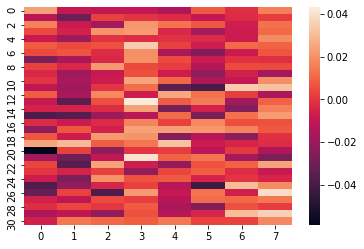

In [84]:
len(res[0])

10

In [39]:
experiment._env._terminal_state.get_amplitudes()

array([-0.70876626+0.01913417j, -0.38731851-0.04619398j,
       -0.51588681-0.03314136j, -0.26780692+0.08001031j])

In [27]:
experiment._env._terminal_state.fidelity_score(experiment._env._target_state)

0.856652121674456

In [36]:
len(experiment.run_inference()[0])

380